In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 831)
(631390, 1)
validation
(74368, 831)
(74368, 1)
test
(85358, 831)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 10:44 - loss: 0.0615 - STD: 2.4583e-04 - MAE: 0.2384

 16/632 [..............................] - ETA: 2s - loss: 0.0225 - STD: 4.3994e-04 - MAE: 0.1105   

 33/632 [>.............................] - ETA: 1s - loss: 0.0180 - STD: 7.0848e-04 - MAE: 0.0902

 49/632 [=>............................] - ETA: 1s - loss: 0.0162 - STD: 0.0012 - MAE: 0.0836    

 63/632 [=>............................] - ETA: 1s - loss: 0.0153 - STD: 0.0024 - MAE: 0.0803

 79/632 [==>...........................] - ETA: 1s - loss: 0.0140 - STD: 0.0072 - MAE: 0.0760

 96/632 [===>..........................] - ETA: 1s - loss: 0.0125 - STD: 0.0190 - MAE: 0.0704

114/632 [====>.........................] - ETA: 1s - loss: 0.0110 - STD: 0.0308 - MAE: 0.0652

132/632 [=====>........................] - ETA: 1s - loss: 0.0100 - STD: 0.0401 - MAE: 0.0611

147/632 [=====>........................] - ETA: 1s - loss: 0.0092 - STD: 0.0459 - MAE: 0.0584

153/632 [======>.......................] - ETA: 2s - loss: 0.0090 - STD: 0.0480 - MAE: 0.0575

169/632 [=======>......................] - ETA: 2s - loss: 0.0084 - STD: 0.0530 - MAE: 0.0552

186/632 [=======>......................] - ETA: 2s - loss: 0.0078 - STD: 0.0574 - MAE: 0.0532

202/632 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0607 - MAE: 0.0514

217/632 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0636 - MAE: 0.0500

233/632 [==========>...................] - ETA: 2s - loss: 0.0067 - STD: 0.0664 - MAE: 0.0487

250/632 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0687 - MAE: 0.0474

266/632 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0708 - MAE: 0.0464

282/632 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0726 - MAE: 0.0454

299/632 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0742 - MAE: 0.0444

316/632 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0758 - MAE: 0.0436

332/632 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0771 - MAE: 0.0428

348/632 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0784 - MAE: 0.0422

364/632 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0795 - MAE: 0.0416

380/632 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0806 - MAE: 0.0411

398/632 [=================>............] - ETA: 1s - loss: 0.0047 - STD: 0.0817 - MAE: 0.0405

415/632 [==================>...........] - ETA: 0s - loss: 0.0045 - STD: 0.0827 - MAE: 0.0401

431/632 [===================>..........] - ETA: 0s - loss: 0.0044 - STD: 0.0834 - MAE: 0.0396

447/632 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0842 - MAE: 0.0392

465/632 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0849 - MAE: 0.0387

482/632 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0857 - MAE: 0.0384

500/632 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0864 - MAE: 0.0380

516/632 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0869 - MAE: 0.0377

534/632 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0876 - MAE: 0.0373

552/632 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0880 - MAE: 0.0370

570/632 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0886 - MAE: 0.0367

587/632 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0890 - MAE: 0.0364

603/632 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0894 - MAE: 0.0362

620/632 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0898 - MAE: 0.0359

632/632 [==============================] - 4s 5ms/step - loss: 0.0035 - STD: 0.0901 - MAE: 0.0358 - val_loss: 0.0017 - val_STD: 0.0788 - val_MAE: 0.0288


Epoch 2/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.0994 - MAE: 0.0269

 18/632 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1042 - MAE: 0.0269 

 34/632 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1042 - MAE: 0.0272

 51/632 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0273

 68/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

 84/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

100/632 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0274

114/632 [====>.........................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

130/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

145/632 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

158/632 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

171/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

187/632 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

204/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

221/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

237/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

252/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

266/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

279/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

293/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

306/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

319/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

332/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0272

346/632 [===============>..............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

359/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

372/632 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0272

385/632 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

398/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

412/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

425/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

439/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

454/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

469/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

486/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

500/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

513/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

529/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

546/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0270

562/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

578/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

594/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

611/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

626/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269 - val_loss: 0.0018 - val_STD: 0.0793 - val_MAE: 0.0293


Epoch 3/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0015 - STD: 0.1037 - MAE: 0.0264

 15/632 [..............................] - ETA: 2s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0293 

 32/632 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0277

 48/632 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0272

 65/632 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0272

 81/632 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0271

 97/632 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0270

110/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

126/632 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

141/632 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

155/632 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

171/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

187/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

200/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

213/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

228/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

244/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

258/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

271/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

287/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0266

304/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

321/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

336/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

349/632 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

365/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0266

379/632 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

394/632 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

409/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

425/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

441/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

459/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

477/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

494/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

511/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

527/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

542/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

555/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

571/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

588/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0266

602/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

617/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

632/632 [==============================] - 2s 4ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0017 - val_STD: 0.0822 - val_MAE: 0.0283


Epoch 4/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0241

 14/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1071 - MAE: 0.0258 

 30/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0260

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

 63/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 80/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 98/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

115/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

132/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

150/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

167/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

184/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

201/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

253/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

288/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

306/632 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

324/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

337/632 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

351/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

364/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

378/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

393/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

406/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

422/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

440/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

454/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

467/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

480/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

498/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

515/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

532/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

558/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

572/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

607/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

620/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

632/632 [==============================] - 2s 4ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260 - val_loss: 0.0017 - val_STD: 0.0857 - val_MAE: 0.0286


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0013 - STD: 0.1140 - MAE: 0.0264

 18/632 [..............................] - ETA: 1s - loss: 0.0014 - STD: 0.1077 - MAE: 0.0259 

 34/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

 51/632 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0266

 67/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

 78/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

 91/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

105/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

122/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

139/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

156/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

172/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

189/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

205/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

221/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

238/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

270/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

286/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

303/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

338/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

356/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

373/632 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

389/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

405/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

421/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

438/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

455/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

472/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

489/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

540/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

556/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

573/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

608/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

625/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

632/632 [==============================] - 2s 3ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257 - val_loss: 0.0017 - val_STD: 0.0820 - val_MAE: 0.0291


Epoch 6/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0015 - STD: 0.1002 - MAE: 0.0261

 18/632 [..............................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271 

 34/632 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

 49/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

 63/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0256

 81/632 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 99/632 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

115/632 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

131/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

147/632 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

164/632 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0253

181/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

197/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0254

213/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0254

229/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0254

245/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0253

263/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

276/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

289/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

321/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0253

338/632 [===============>..............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0253

354/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

370/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

384/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

397/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

409/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

421/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

434/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

446/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

458/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

472/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

488/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

505/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

518/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

533/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

550/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

567/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

583/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

600/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

617/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252 - val_loss: 0.0015 - val_STD: 0.0832 - val_MAE: 0.0271


Epoch 7/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0011 - STD: 0.1105 - MAE: 0.0236

 16/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1047 - MAE: 0.0255 

 32/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0253

 48/632 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0253

 64/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0251

 80/632 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0251

 97/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

113/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0251

129/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

145/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

161/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0250

177/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

194/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

210/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

223/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

235/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

248/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

260/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

274/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0251

286/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0252

299/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0252

311/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

326/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

342/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

358/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

374/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

390/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

407/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251

424/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0250

440/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

456/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

473/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0250

489/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0250

505/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

521/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

554/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

570/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

587/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

603/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0249

619/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248

632/632 [==============================] - 2s 4ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0248 - val_loss: 0.0015 - val_STD: 0.0832 - val_MAE: 0.0266


Epoch 8/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0012 - STD: 0.1086 - MAE: 0.0238

 13/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1085 - MAE: 0.0239 

 28/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0242

 43/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0248

 58/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 72/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

 88/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0250

105/632 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0248

122/632 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0247

139/632 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

156/632 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

172/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0245

189/632 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0245

203/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0246

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

233/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0247

250/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0246

267/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

284/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0246

300/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

318/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0246

334/632 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

353/632 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

372/632 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0246

391/632 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0246

409/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

426/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

444/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

462/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

480/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0245

498/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0245

516/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

533/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

549/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

566/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

583/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

601/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

618/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244

632/632 [==============================] - 2s 3ms/step - loss: 0.0013 - STD: 0.1066 - MAE: 0.0244 - val_loss: 0.0015 - val_STD: 0.0834 - val_MAE: 0.0266


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0013 - STD: 0.1075 - MAE: 0.0247

 16/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0240 

 33/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0241

 50/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0240

 66/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

 82/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

 94/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

110/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0240

127/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

143/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0239

160/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

176/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

194/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

211/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

228/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0239

244/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

257/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0239

271/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

284/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

297/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

310/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

323/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

338/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

355/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0239

372/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

389/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

403/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

419/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

433/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0241

448/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

464/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0241

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

492/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

505/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

522/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0241

538/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

552/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

568/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0240

585/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

601/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

615/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

631/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240

632/632 [==============================] - 2s 4ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0240 - val_loss: 0.0015 - val_STD: 0.0861 - val_MAE: 0.0274


Epoch 10/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0013 - STD: 0.1109 - MAE: 0.0262

 14/632 [..............................] - ETA: 2s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0241 

 26/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0241

 38/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0242

 51/632 [=>............................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

 67/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

 82/632 [==>...........................] - ETA: 2s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

 97/632 [===>..........................] - ETA: 2s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

115/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

131/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

144/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

156/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

168/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

181/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

193/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

205/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

218/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

230/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

242/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

254/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

268/632 [===========>..................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

281/632 [============>.................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

295/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

309/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

326/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0237

340/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

357/632 [===============>..............] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0237

374/632 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

391/632 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

408/632 [==================>...........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

422/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

436/632 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0236

452/632 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

465/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

478/632 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

490/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

502/632 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

514/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

526/632 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0237

539/632 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

552/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

567/632 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

581/632 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

594/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

606/632 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

618/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

630/632 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

632/632 [==============================] - 3s 4ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236 - val_loss: 0.0015 - val_STD: 0.0836 - val_MAE: 0.0263


Epoch 11/10000


  1/632 [..............................] - ETA: 11s - loss: 9.6627e-04 - STD: 0.0981 - MAE: 0.0226

 18/632 [..............................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0238     

 31/632 [>.............................] - ETA: 2s - loss: 0.0012 - STD: 0.1079 - MAE: 0.0236

 43/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1082 - MAE: 0.0235

 55/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0235

 68/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

 83/632 [==>...........................] - ETA: 2s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

 98/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0234

113/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

127/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

143/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

158/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

175/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

189/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

203/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

219/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

236/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

253/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0234

270/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

288/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

305/632 [=============>................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0235

322/632 [==============>...............] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0236

339/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

356/632 [===============>..............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

373/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

389/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

405/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

422/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0235

439/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

456/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

473/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

489/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

507/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

525/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

542/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

559/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

592/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

610/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

626/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235 - val_loss: 0.0018 - val_STD: 0.0870 - val_MAE: 0.0280


Epoch 12/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0010 - STD: 0.1120 - MAE: 0.0219

 18/632 [..............................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0237 

 36/632 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1055 - MAE: 0.0239

 53/632 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0242

 70/632 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0241

 86/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0240

102/632 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

116/632 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

130/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

147/632 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0236

164/632 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

180/632 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

197/632 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

213/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0236

230/632 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

247/632 [==========>...................] - ETA: 1s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0236

264/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0235

281/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

298/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

315/632 [=============>................] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0234

332/632 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

349/632 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

366/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

382/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0234

400/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1069 - MAE: 0.0233

418/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

435/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

452/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

469/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0233

486/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0233

504/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

521/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0232

537/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

553/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

570/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

586/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0232

603/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

620/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232

632/632 [==============================] - 2s 3ms/step - loss: 0.0011 - STD: 0.1073 - MAE: 0.0232 - val_loss: 0.0015 - val_STD: 0.0827 - val_MAE: 0.0262


Epoch 13/10000


  1/632 [..............................] - ETA: 10s - loss: 9.3187e-04 - STD: 0.1018 - MAE: 0.0214

 16/632 [..............................] - ETA: 2s - loss: 0.0011 - STD: 0.1084 - MAE: 0.0225     

 28/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0227

 41/632 [>.............................] - ETA: 2s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0226

 57/632 [=>............................] - ETA: 2s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0228

 73/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1073 - MAE: 0.0226

 89/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

105/632 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

121/632 [====>.........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

134/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

147/632 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0228

162/632 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

176/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

188/632 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

201/632 [========>.....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

213/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0228

226/632 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

241/632 [==========>...................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

258/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

272/632 [===========>..................] - ETA: 1s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0229

285/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

298/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0229

310/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

322/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

334/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

349/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

361/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

376/632 [================>.............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

393/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

410/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

426/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

442/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0229

455/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

471/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

485/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

498/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

511/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

524/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

536/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

549/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

562/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

575/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

589/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

604/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0229

616/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0229

629/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1076 - MAE: 0.0228

632/632 [==============================] - 3s 4ms/step - loss: 0.0011 - STD: 0.1075 - MAE: 0.0228 - val_loss: 0.0016 - val_STD: 0.0864 - val_MAE: 0.0271


Epoch 14/10000


  1/632 [..............................] - ETA: 13s - loss: 8.9383e-04 - STD: 0.1120 - MAE: 0.0210

 13/632 [..............................] - ETA: 2s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0222     

 26/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1064 - MAE: 0.0221

 40/632 [>.............................] - ETA: 2s - loss: 0.0010 - STD: 0.1081 - MAE: 0.0223

 53/632 [=>............................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0223

 66/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1071 - MAE: 0.0224

 78/632 [==>...........................] - ETA: 2s - loss: 0.0010 - STD: 0.1073 - MAE: 0.0224

 92/632 [===>..........................] - ETA: 2s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0224

107/632 [====>.........................] - ETA: 2s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

121/632 [====>.........................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0224

135/632 [=====>........................] - ETA: 1s - loss: 0.0010 - STD: 0.1080 - MAE: 0.0225

148/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

162/632 [======>.......................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0225

174/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0225

186/632 [=======>......................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

200/632 [========>.....................] - ETA: 1s - loss: 0.0010 - STD: 0.1076 - MAE: 0.0226

212/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

225/632 [=========>....................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

240/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

252/632 [==========>...................] - ETA: 1s - loss: 0.0010 - STD: 0.1079 - MAE: 0.0226

265/632 [===========>..................] - ETA: 1s - loss: 0.0010 - STD: 0.1078 - MAE: 0.0226

278/632 [============>.................] - ETA: 1s - loss: 0.0011 - STD: 0.1077 - MAE: 0.0226

291/632 [============>.................] - ETA: 1s - loss: 0.0010 - STD: 0.1077 - MAE: 0.0226

305/632 [=============>................] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

317/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

330/632 [==============>...............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

342/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

356/632 [===============>..............] - ETA: 1s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

372/632 [================>.............] - ETA: 1s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

385/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

399/632 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

416/632 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

433/632 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

450/632 [====================>.........] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

465/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

482/632 [=====================>........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

498/632 [======================>.......] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0227

514/632 [=======================>......] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

528/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

544/632 [========================>.....] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0227

560/632 [=========================>....] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0227

577/632 [==========================>...] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

594/632 [===========================>..] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

611/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

627/632 [============================>.] - ETA: 0s - loss: 0.0011 - STD: 0.1075 - MAE: 0.0227

632/632 [==============================] - 3s 4ms/step - loss: 0.0011 - STD: 0.1076 - MAE: 0.0227 - val_loss: 0.0019 - val_STD: 0.0855 - val_MAE: 0.0293


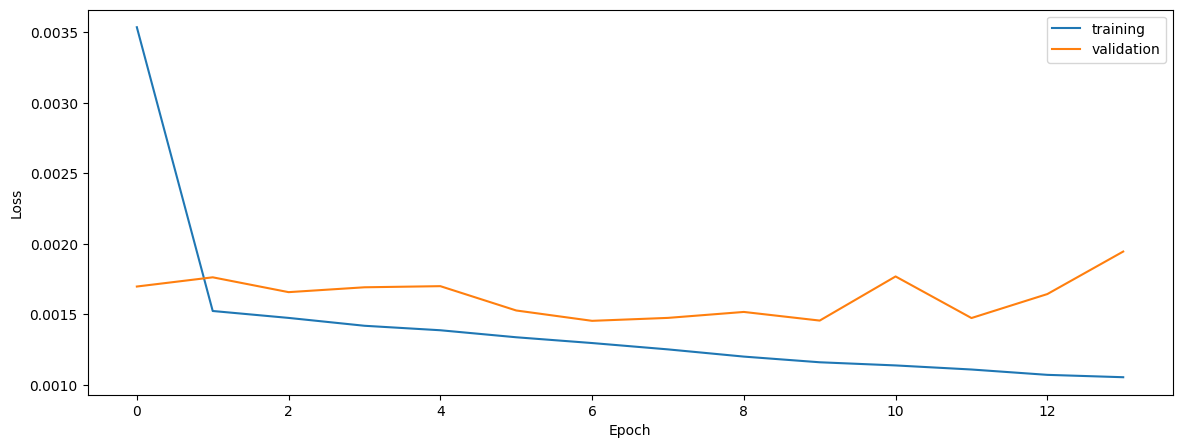

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


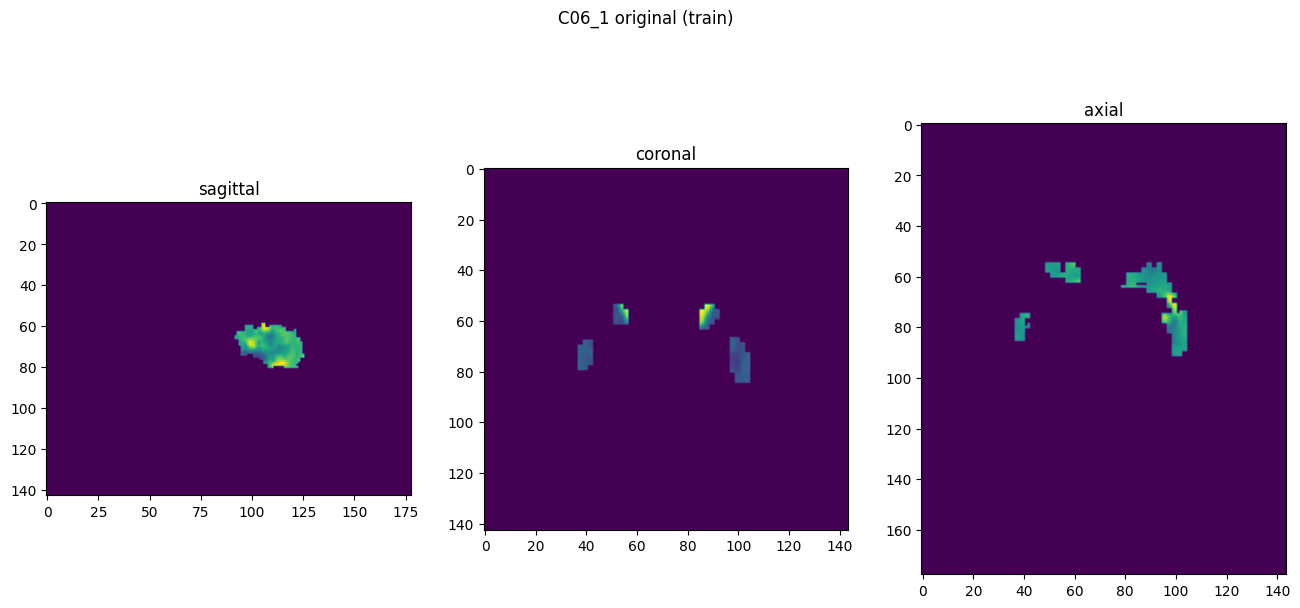

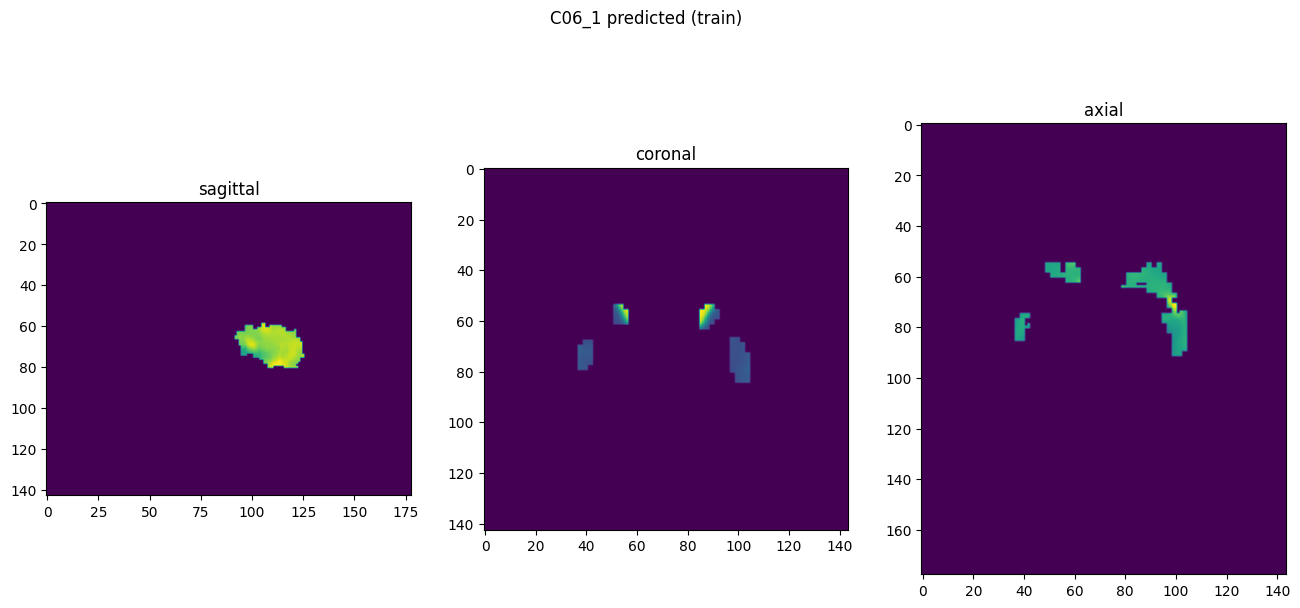

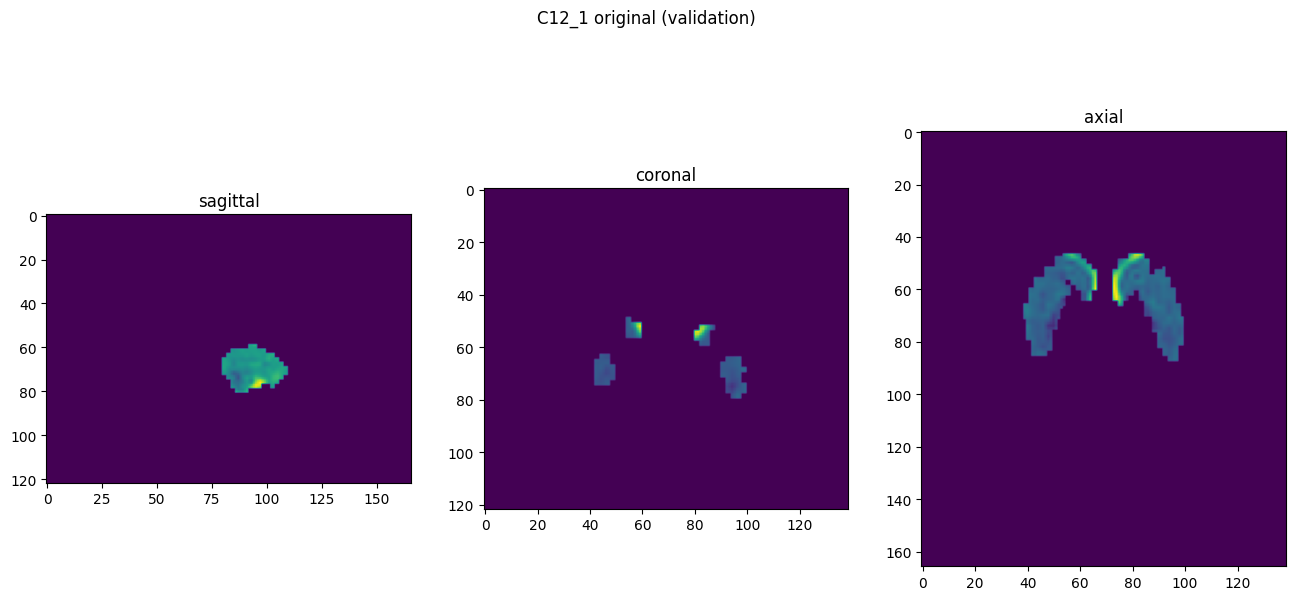

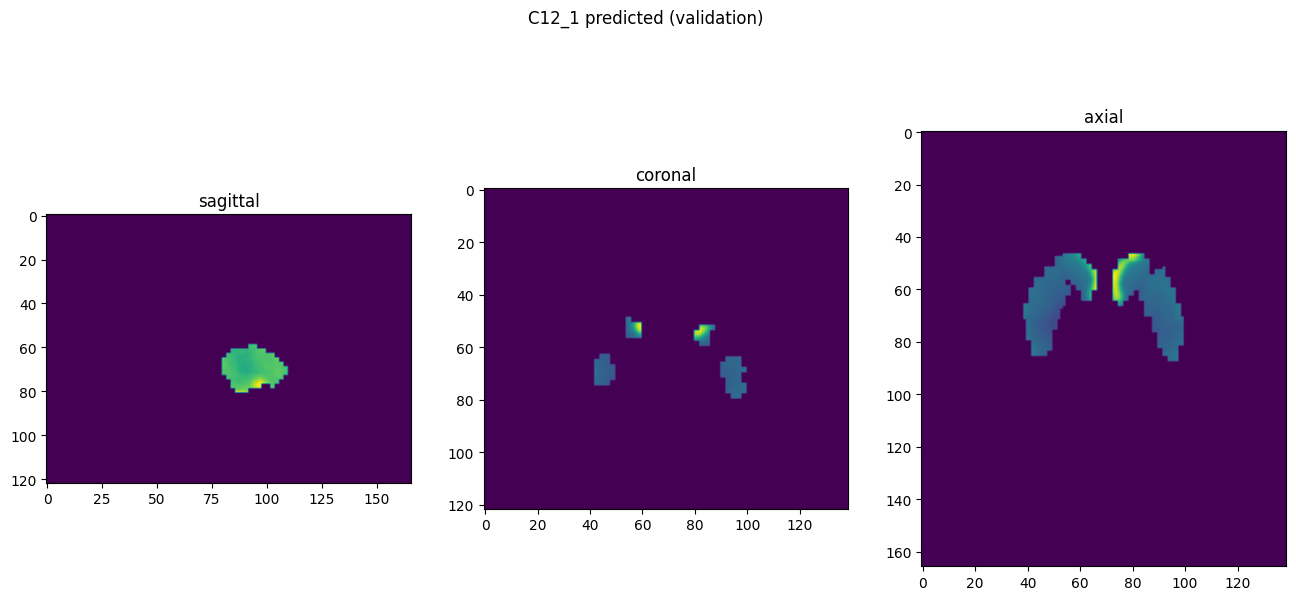

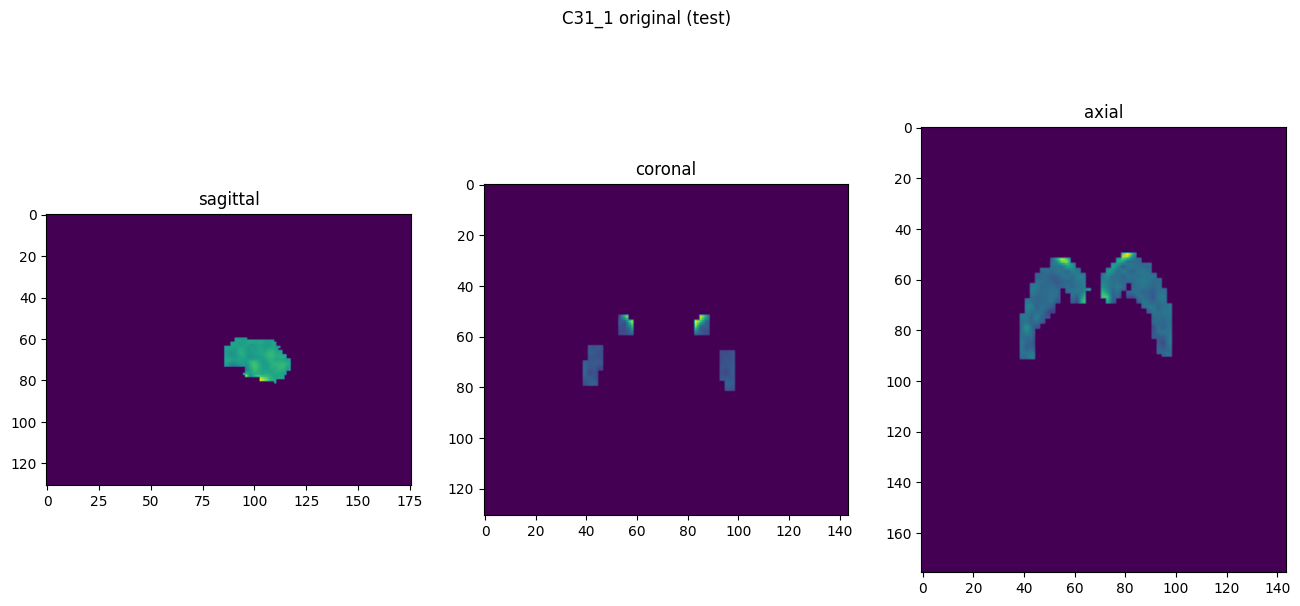

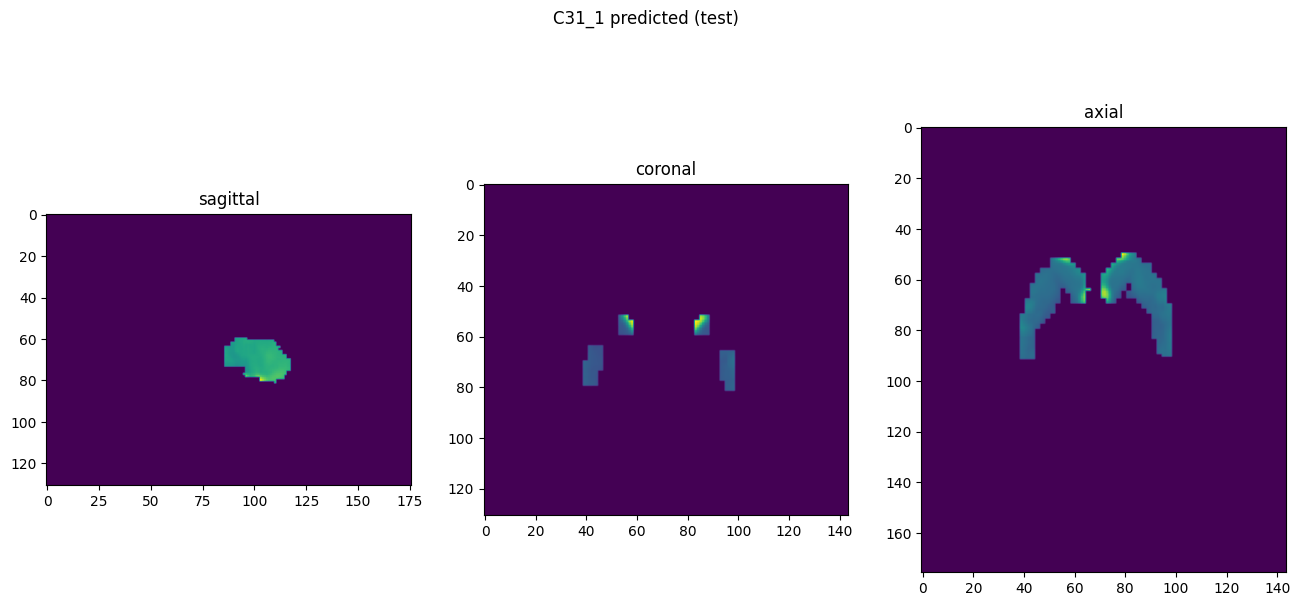

In [10]:
showResults(model, gen, threshold=None, background=False)